In [1]:
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple, to_plot
from snn_delays.utils.test_behavior import tb_addtask_refact
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
time_window = 50
batch_size = 32 # 128: anil kag

ckpt_dir = 'multiaddtask_04_2025_tests'

dataset = 'copymemory_episodic'

num_epochs = 5000 # important: epochs here refer to iteration steps

dataset_size = batch_size*num_epochs

DL = DatasetLoader(dataset=dataset, caching='gpu', 
                   dataset_size = dataset_size,
                   num_workers=0, batch_size=batch_size, 
                   total_time=time_window)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()
dataset_dict["time_ms"] = 2e3

for img, lbl in train_loader:
    print(img.shape)
    print(lbl.shape)
    break

Initializing GPU cache for 160000 samples...
Cache initialized in 23.03 seconds
Initializing GPU cache for 32 samples...
Cache initialized in 0.01 seconds
torch.Size([32, 50, 3])
torch.Size([32, 5, 5])


In [3]:
num_h = 64

tau_m = 'log-uniform-st'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms


SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=3, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=1152, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=5, bias=False)
    )
  )
)

Frozen taus

In [4]:
lr_tau = 1.0
train(snn_f, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100, freeze_taus=True)
train(snn_rnn, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100, freeze_taus=True)
train(snn_rd, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100, freeze_taus=True)

Epoch [1/1], learning_rates 0.001000, 1.000000
Step [50/5000], Loss: 0.11451
Step [100/5000], Loss: 0.08328
Step [150/5000], Loss: 0.07214
Step [200/5000], Loss: 0.06818
Step [250/5000], Loss: 0.06005
Step [300/5000], Loss: 0.06204
Step [350/5000], Loss: 0.05804
Step [400/5000], Loss: 0.04835
Step [450/5000], Loss: 0.05180
Step [500/5000], Loss: 0.03816
Step [550/5000], Loss: 0.03528
Step [600/5000], Loss: 0.04235
Step [650/5000], Loss: 0.03465
Step [700/5000], Loss: 0.02999
Step [750/5000], Loss: 0.02901
Step [800/5000], Loss: 0.02707
Step [850/5000], Loss: 0.02975
Step [900/5000], Loss: 0.02883
Step [950/5000], Loss: 0.02827
Step [1000/5000], Loss: 0.02743
Step [1050/5000], Loss: 0.02324
Step [1100/5000], Loss: 0.02129
Step [1150/5000], Loss: 0.02127
Step [1200/5000], Loss: 0.02075
Step [1250/5000], Loss: 0.01797
Step [1300/5000], Loss: 0.02279
Step [1350/5000], Loss: 0.02210
Step [1400/5000], Loss: 0.02000
Step [1450/5000], Loss: 0.01799
Step [1500/5000], Loss: 0.02208
Step [1550/50

Text(0.5, 1.0, 'train loss')

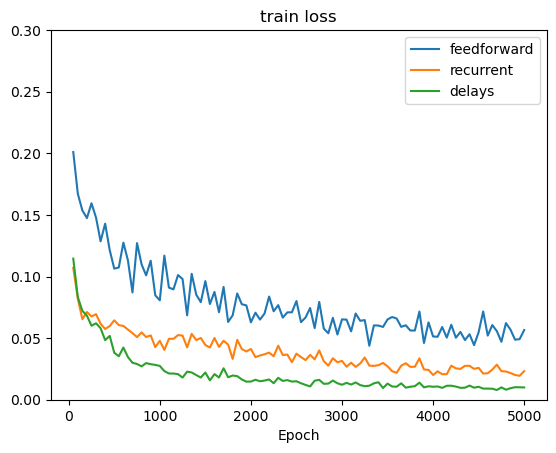

In [5]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')

plt.ylim(0, 0.3)
plt.title('train loss')

In [6]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()

from snn_delays.utils.train_utils_refact_minimal import propagate_batch_simple
images, labels_mf = propagate_batch_simple(snn_f, test_loader)
_, labels_rnn = propagate_batch_simple(snn_rnn, test_loader)
_, labels_rd = propagate_batch_simple(snn_rd, test_loader)

In [7]:
ref_mf = labels_mf[:,:int(0.1*time_window), :].permute(1, 0, 2).cpu().numpy()
out_mf = snn_f.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rnn = labels_rnn[:,:int(0.1*time_window), :].permute(1, 0, 2).cpu().numpy()
out_rnn = snn_rnn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rd = labels_rd[:,:int(0.1*time_window),:].permute(1, 0, 2).cpu().numpy()
out_rd = snn_rd.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

from snn_delays.utils.visualization_utils import plot_add_task, plot_add_task2, plot_add_task3, plot_add_task4
# Create a figure with 3 rows and N columns (for stacking results horizontally)

def plot_add_task(output, reference, N, axes=None, name=''):

    ns = 50 # num samples to display for better viz

    ref = reference[:, :ns , N]
    out = output[:, :ns , N]
    diff = abs(ref-out)

    print(np.mean(diff))

    if axes is None:
        fig, axes = plt.subplots(3, 1, figsize=(5, 10))  # Create a new figure if axes not provided

    axes[0].imshow(ref, vmin=0, vmax=0.9)
    axes[0].set_title('Reference '+name)
    axes[0].set_ylabel('Time')

    axes[1].imshow(out, vmin=0, vmax=0.9)
    axes[1].set_title('Output')
    axes[1].set_ylabel('Time')

    axes[2].imshow(diff, vmin=0.0, vmax=0.5)
    axes[2].set_title('Difference')
    axes[2].set_ylabel('Time')
    axes[2].set_xlabel('Training Sample')

    return axes  # Return the axes to be used in an external figure

0.16722962
0.12156985
0.082093954


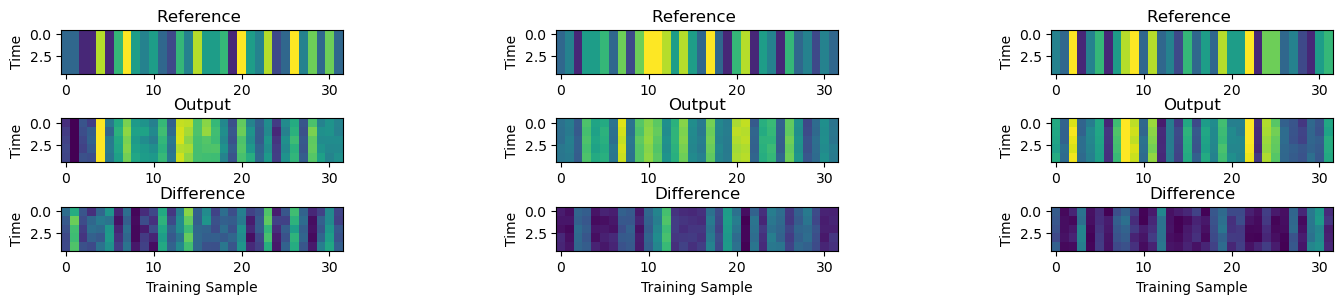

0.19593596
0.124431334
0.06904926


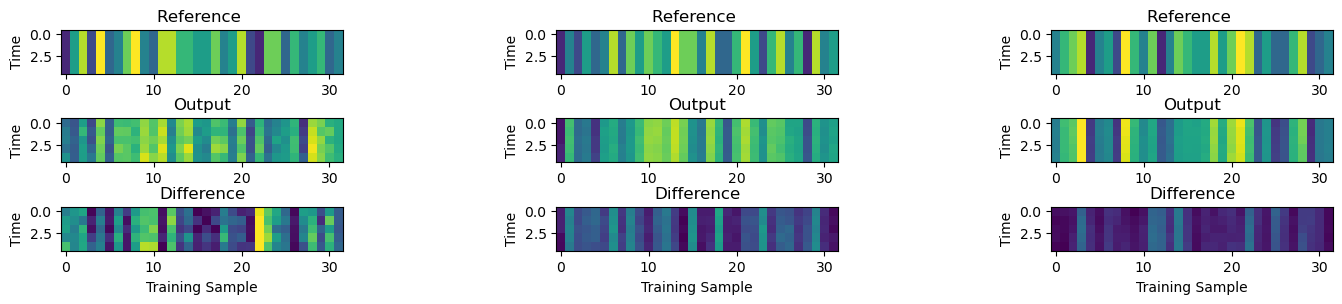

0.20378263
0.12619822
0.091525175


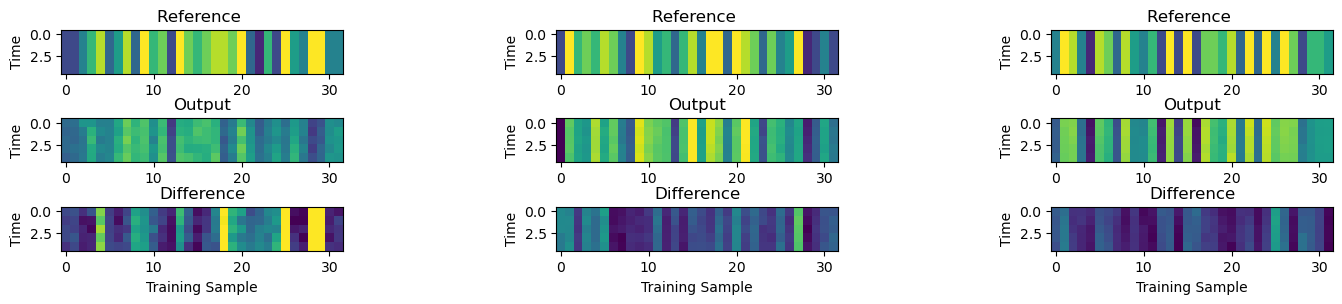

0.18795462
0.12702891
0.07973358


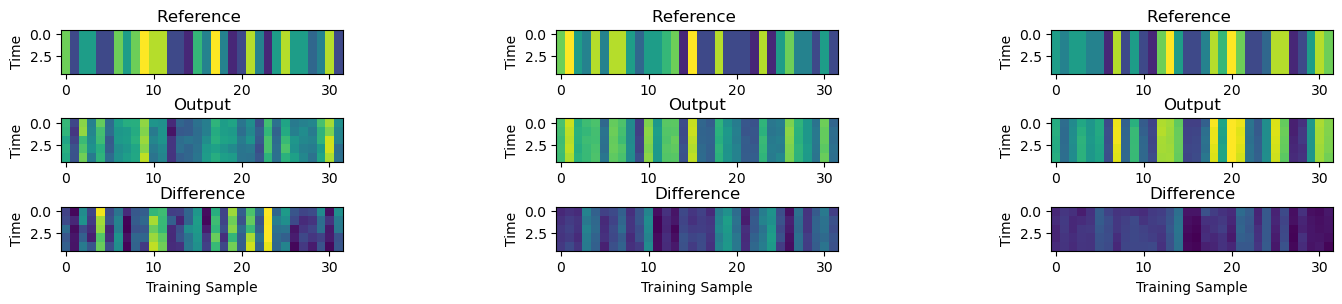

0.16440466
0.117555596
0.08459593


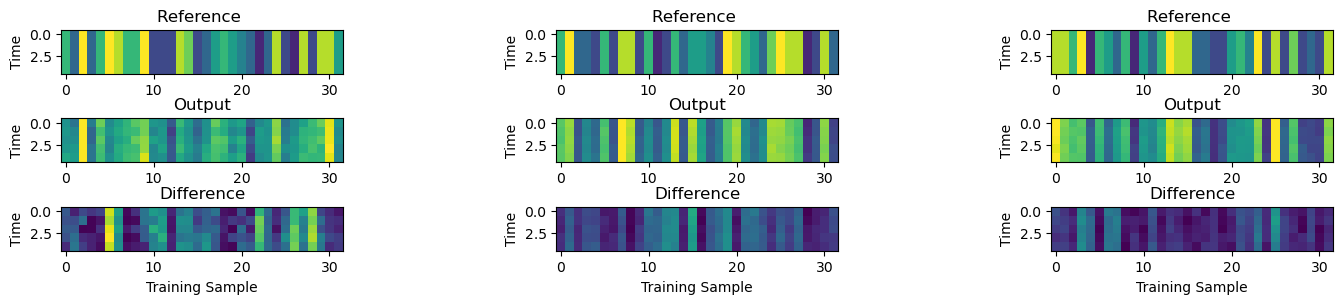

In [8]:
for out_neuron in range(5):

    fig, axes = plt.subplots(3, 3, figsize=(15, 3))  # 3 rows, 2 columns

    plot_add_task(out_mf, ref_mf, out_neuron, axes[:, 0])  
    plot_add_task(out_rnn, ref_rnn, out_neuron, axes[:, 1])  
    plot_add_task(out_rd, ref_rd, out_neuron, axes[:, 2])  

    plt.tight_layout()
    plt.show()

In [9]:
dataset = 'copymemory_episodic'

num_epochs = 1 # important: epochs here refer to iteration steps
dataset_size = batch_size*num_epochs

DL = DatasetLoader(dataset=dataset, caching='gpu', 
                   dataset_size = dataset_size,
                   num_workers=0, batch_size=batch_size, 
                   total_time=time_window, shuffle=False)

Initializing GPU cache for 32 samples...
Cache initialized in 0.01 seconds
Initializing GPU cache for 32 samples...
Cache initialized in 0.01 seconds


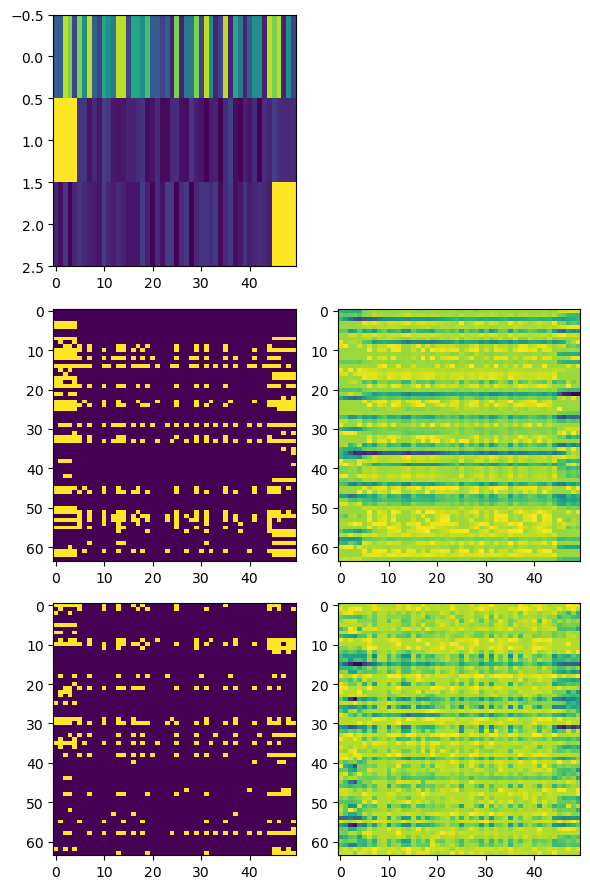

In [10]:
images, labels_mf = propagate_batch_simple(snn_f, test_loader)
spk = snn_f.spike_state
mem = snn_f.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

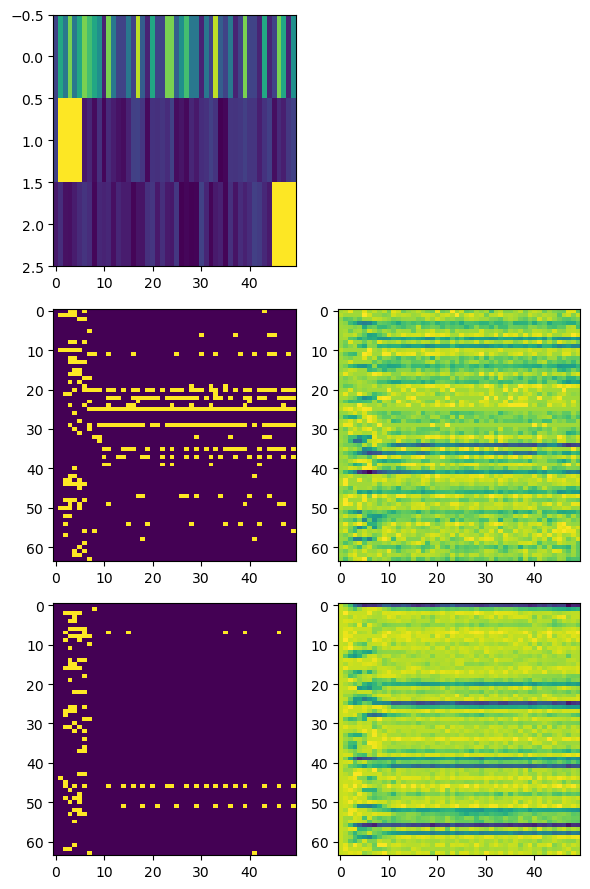

In [11]:
images, labels = propagate_batch_simple(snn_rnn, test_loader)
spk = snn_rnn.spike_state
mem = snn_rnn.mem_state
N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

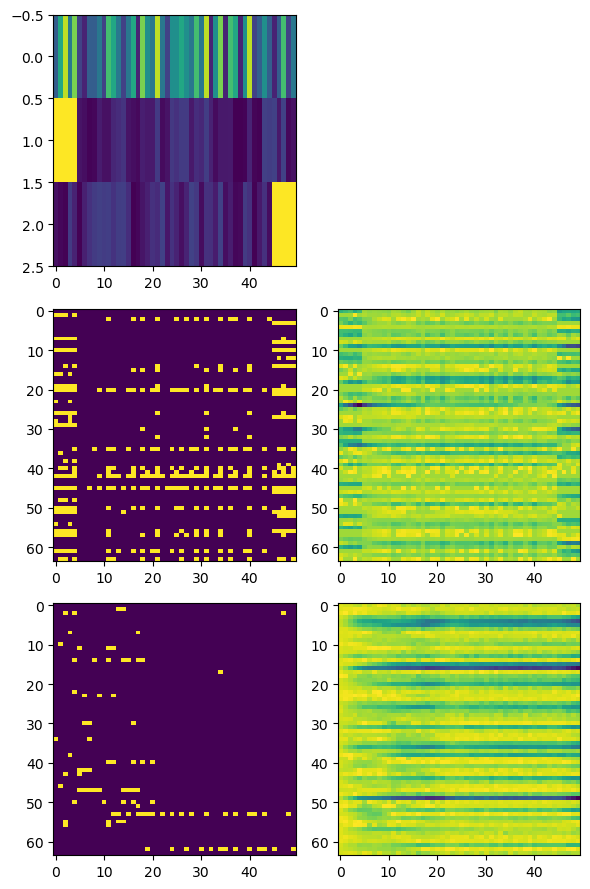

In [12]:
images, labels = propagate_batch_simple(snn_rd, test_loader)
spk = snn_rd.spike_state
mem = snn_rd.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()